<a href="https://colab.research.google.com/github/kassemm/LAB3AV/blob/dependabot%2Fpip%2Fdocs%2Fpygments-2.7.4/Lab3/Lab3_Highway_DQN_rlagentsChangeLanes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This configuration is with 10 vehicles, the agent is configured to act greedy for simplicity and to have deterministic actions. The reward of changing lanes is lower than the reward for collision so the agent prefers collision and doesn't change lane. 


# Training a DQN on `highway-v0` with rlagents
## Import requirements

In [1]:
# Environment
##!pip install highway-env
!pip install git+https://github.com/kassemm/highway-env
import gym
import highway_env

# Agent
##!pip install git+https://github.com/eleurent/rl-agents
!pip install git+https://github.com/kassemm/rl-agents


# Visualisation utils
import sys
%load_ext tensorboard
!pip install tensorboardx gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg
#!git clone https://github.com/eleurent/highway-env.git
!git clone https://github.com/kassemm/highway-env.git
sys.path.insert(0, '/content/highway-env/scripts/')
from utils import show_videos


from rl_agents.trainer.evaluation import Evaluation
from rl_agents.agents.common.factory import load_agent, load_environment

# Get the environment and agent configurations from the rl-agents repository
##!git clone https://github.com/eleurent/rl-agents.git
!git clone https://github.com/kassemm/rl-agents.git


  Cloning https://github.com/kassemm/highway-env to /tmp/pip-req-build-j2sb6gso
  Running command git clone -q https://github.com/kassemm/highway-env /tmp/pip-req-build-j2sb6gso
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 11.8MB 10.1MB/s 
  Created wheel for highway-env: filename=highway_env-1.2-cp37-none-any.whl size=92452 sha256=e4cc8b9bc8ece360a4bc0110fa15ea39d981202f93cf646f94b944fc24fbeca7
  Stored in directory: /tmp/pip-ephem-wheel-cache-0tvqy8x0/wheels/06/73/17/d77e7e0346dec11ec4701f52e862b716fe373543407cf9a53f
Successfully built highway-env
  Cloning https://github.com/kassemm/rl-agents to /tmp/pip-req-build-s4bj7p3l
  Running command git clone -q https://github.com/kassemm/rl-agents /tmp/pip-req-build-s4bj7p3l
     |████████████████████████████████| 122kB 13.7MB/s 
  Created wheel for rl-agents: filename=rl_agents-

In [2]:
%cd /content/rl-agents/scripts/
env_config = 'configs/HighwayEnv/env.json'
agent_config = 'configs/HighwayEnv/agents/DQNAgent/dqn.json' ##Agent is configured to act greedy
f=open(agent_config,"r");
print(f.read())

/content/rl-agents/scripts
{
    "__class__": "<class 'rl_agents.agents.deep_q_network.pytorch.DQNAgent'>",
    "model": {
        "type": "MultiLayerPerceptron",
        "layers": [256, 256]
    },
    "double": false,
    "gamma": 0.8,
    "n_steps": 1,
    "batch_size": 32,
    "memory_capacity": 15000,
    "target_update": 50,
    "exploration": {
        "method": "Greedy",
        "tau": 6000,
        "temperature": 1.0,
        "final_temperature": 0.05
    },
    "loss_function": "l2"
}



## Training

Prepare environment, agent, and evaluation process.


The reward scheme is changed in the file https://github.com/kassemm/highway-env/blob/master/highway_env/envs/highway_env.py

"lane_change_reward" is added to the total reward. Also, the minimum reward is adjusted to be collision_reward+lane_chane_reward.

        reward = + self.config["collision_reward"] * self.vehicle.crashed + self.config["right_lane_reward"] * lane / max(len(neighbours) - 1, 1)    
        + self.config["high_speed_reward"] * np.clip(scaled_speed, 0, 1)
        + self.config["lane_change_reward"] * lane_change
            
        reward = utils.lmap(reward,
                          [self.config["collision_reward"]+ self.config["lane_change_reward"],
                           self.config["high_speed_reward"] + self.config["right_lane_reward"]],
                          [0, 1])
        reward = 0 if not self.vehicle.on_road els


{'action': {'type': 'DiscreteMetaAction'},
 'centering_position': [0.3, 0.5],
 'collision_reward': -1,
 'controlled_vehicles': 1,
 'duration': 40,
 'ego_spacing': 2,
 'high_speed_reward': 0.4,
 'id': 'highway-v0',
 'import_module': 'highway_env',
 'initial_lane_id': 0,
 'lane_change_reward': -1.75,
 'lanes_count': 2,
 'manual_control': False,
 'observation': {'type': 'Kinematics'},
 'offroad_terminal': False,
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 1,
 'real_time_rendering': False,
 'render_agent': True,
 'reward_speed_range': [20, 30],
 'right_lane_reward': 0.1,
 'scaling': 5.5,
 'screen_height': 150,
 'screen_width': 600,
 'show_trajectories': False,
 'simulation_frequency': 15,
 'vehicles_count': 10,
 'vehicles_density': 1}
Agent Config
'configs/HighwayEnv/agents/DQNAgent/dqn.json'


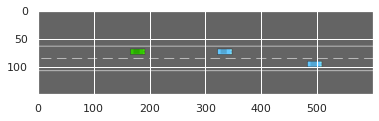

Ready to train <rl_agents.agents.deep_q_network.pytorch.DQNAgent object at 0x7f82c0ce1790> on <HighwayEnv<highway-v0>>


In [3]:


env = load_environment(env_config)
import pprint
from matplotlib import pyplot as plt
env.config["lane_change_reward"] = -1.75  ##-ve value
env.config["vehicles_count"] = 10  #change number of cars
env.config["right_lane_reward"]=0.1 
#env.config['reward_speed_range'] = [0, 100]
env.config["lanes_count"] = 2
env.config["initial_lane_id"] = 0
pprint.pprint(env.config)
print("Agent Config")
pprint.pprint(agent_config)


env.reset()
plt.imshow(env.render(mode="rgb_array"))
plt.show()

agent = load_agent(agent_config, env)
evaluation = Evaluation(env, agent, num_episodes=1000, display_env=False)
print(f"Ready to train {agent} on {env}")

Start training. Run tensorboard locally to visualize training.

In [4]:
#tensorboard --logdir "{evaluation.directory}"
evaluation.train()

[INFO] Episode 0 score: 10.7 
[INFO] Episode 1 score: 9.8 
[INFO] Episode 2 score: 3.9 
[INFO] Episode 3 score: 11.5 
[INFO] Episode 4 score: 3.1 
[INFO] Episode 5 score: 4.8 
[INFO] Episode 6 score: 2.2 
[INFO] Episode 7 score: 4.8 
[INFO] Episode 8 score: 4.8 
[INFO] Episode 9 score: 4.8 
[INFO] Episode 10 score: 3.9 
[INFO] Episode 11 score: 3.9 
[INFO] Episode 12 score: 10.7 
[INFO] Episode 13 score: 2.2 
[INFO] Episode 14 score: 2.2 
[INFO] Episode 15 score: 2.2 
[INFO] Episode 16 score: 5.6 
[INFO] Episode 17 score: 3.9 
[INFO] Episode 18 score: 5.6 
[INFO] Episode 19 score: 4.8 
[INFO] Episode 20 score: 3.1 
[INFO] Episode 21 score: 3.1 
[INFO] Episode 22 score: 2.2 
[INFO] Episode 23 score: 7.3 
[INFO] Episode 24 score: 2.2 
[INFO] Episode 25 score: 3.9 
[INFO] Episode 26 score: 3.9 
[INFO] Episode 27 score: 5.6 
[INFO] Episode 28 score: 10.7 
[INFO] Episode 29 score: 2.2 
[INFO] Episode 30 score: 2.2 
[INFO] Episode 31 score: 3.9 
[INFO] Episode 32 score: 7.3 
[INFO] Episode 3

INFO: Finished writing results. You can upload them to the scoreboard via gym.upload('/content/rl-agents/scripts/out/HighwayEnv/DQNAgent/run_20210526-182914_58')


In [7]:
 #gym.upload('/content/rl-agents/scripts/out/HighwayEnv/DQNAgent/run_20210523-212333_58')

Progress can be visualised in the tensorboard cell above, which should update every 30s (or manually). You may need to click the *Fit domain to data* buttons below each graph.

## Testing

Run the learned policy for a few episodes. The vehicle prefers to collide than to change lane. Since the reward of from collision (-1)is higher than the reward from changing lane(-1.7)

In [9]:
#env = load_environment(env_config)
"""
agent_config = {
    "__class__": "<class 'rl_agents.agents.tree_search.deterministic.DeterministicPlannerAgent'>",
    "env_preprocessors": [{"method":"simplify"}],
    "budget": 50,
    "gamma": 0.7,
}

"""


env.configure({"offscreen_rendering": True})
agent = load_agent(agent_config, env)
evaluation = Evaluation(env, agent, num_episodes=7, recover=True)
evaluation.test()
show_videos(evaluation.run_directory)

[INFO] Choosing GPU device: 0, memory used: 1333 
[INFO] Loaded DQNAgent model from out/HighwayEnv/DQNAgent/saved_models/latest.tar 


INFO: Creating monitor directory out/HighwayEnv/DQNAgent/run_20210526-184026_58
INFO: Starting new video recorder writing to /content/rl-agents/scripts/out/HighwayEnv/DQNAgent/run_20210526-184026_58/openaigym.video.3.58.video000000.mp4


[INFO] Episode 0 score: 3.9 


INFO: Starting new video recorder writing to /content/rl-agents/scripts/out/HighwayEnv/DQNAgent/run_20210526-184026_58/openaigym.video.3.58.video000001.mp4


[INFO] Episode 1 score: 4.8 


INFO: Starting new video recorder writing to /content/rl-agents/scripts/out/HighwayEnv/DQNAgent/run_20210526-184026_58/openaigym.video.3.58.video000002.mp4


[INFO] Episode 2 score: 2.2 


INFO: Starting new video recorder writing to /content/rl-agents/scripts/out/HighwayEnv/DQNAgent/run_20210526-184026_58/openaigym.video.3.58.video000003.mp4


[INFO] Episode 3 score: 5.6 


INFO: Starting new video recorder writing to /content/rl-agents/scripts/out/HighwayEnv/DQNAgent/run_20210526-184026_58/openaigym.video.3.58.video000004.mp4


[INFO] Episode 4 score: 3.9 


INFO: Starting new video recorder writing to /content/rl-agents/scripts/out/HighwayEnv/DQNAgent/run_20210526-184026_58/openaigym.video.3.58.video000005.mp4


[INFO] Episode 5 score: 2.2 


INFO: Starting new video recorder writing to /content/rl-agents/scripts/out/HighwayEnv/DQNAgent/run_20210526-184026_58/openaigym.video.3.58.video000006.mp4


[INFO] Episode 6 score: 1.4 


INFO: Finished writing results. You can upload them to the scoreboard via gym.upload('/content/rl-agents/scripts/out/HighwayEnv/DQNAgent/run_20210526-184026_58')
